In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from faker import Faker
import json

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuración inicial
fake = Faker('es_MX')
np.random.seed(42)
random.seed(42)

In [1]:
pip install faker

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/1.9 MB 2.4 MB/s eta 0:00:01
   --------------------- ------------------ 1.0/1.9 MB 2.3 MB/s eta 0:00:01
   -------------------------------- ------- 1.6/1.9 MB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Configuración de centros de salud rurales en Michoacán
CENTROS_SALUD = [
    {"id": "CS001", "nombre": "Centro de Salud Tzitzio", "lat": 19.5833, "lon": -100.9167, "tipo": "Básico"},
    {"id": "CS002", "nombre": "Centro de Salud Tiquicheo", "lat": 18.8833, "lon": -100.7500, "tipo": "Básico"},
    {"id": "CS003", "nombre": "Centro de Salud Madero", "lat": 19.4000, "lon": -101.1167, "tipo": "Ampliado"},
    {"id": "CS004", "nombre": "Centro de Salud Susupuato", "lat": 19.2167, "lon": -100.4000, "tipo": "Básico"},
    {"id": "CS005", "nombre": "Hospital Rural Tuzantla", "lat": 19.2000, "lon": -100.5667, "tipo": "Hospital"}
]

# Enfermedades comunes en zonas rurales
ENFERMEDADES_COMUNES = [
    {"codigo": "A09", "nombre": "Diarrea y gastroenteritis", "peso": 0.20},
    {"codigo": "J06", "nombre": "Infecciones respiratorias agudas", "peso": 0.25},
    {"codigo": "E11", "nombre": "Diabetes tipo 2", "peso": 0.15},
    {"codigo": "I10", "nombre": "Hipertensión esencial", "peso": 0.15},
    {"codigo": "B82", "nombre": "Parasitosis intestinal", "peso": 0.10},
    {"codigo": "A90", "nombre": "Dengue", "peso": 0.05},
    {"codigo": "N39", "nombre": "Infección de vías urinarias", "peso": 0.05},
    {"codigo": "K29", "nombre": "Gastritis", "peso": 0.05}
]

# Medicamentos comunes
MEDICAMENTOS = [
    {"codigo": "MED001", "nombre": "Paracetamol 500mg", "tipo": "Analgésico", "presentacion": "Tabletas"},
    {"codigo": "MED002", "nombre": "Amoxicilina 500mg", "tipo": "Antibiótico", "presentacion": "Cápsulas"},
    {"codigo": "MED003", "nombre": "Metformina 850mg", "tipo": "Antidiabético", "presentacion": "Tabletas"},
    {"codigo": "MED004", "nombre": "Losartán 50mg", "tipo": "Antihipertensivo", "presentacion": "Tabletas"},
    {"codigo": "MED005", "nombre": "Albendazol 400mg", "tipo": "Antiparasitario", "presentacion": "Tabletas"},
    {"codigo": "MED006", "nombre": "Suero oral", "tipo": "Rehidratación", "presentacion": "Sobre"},
    {"codigo": "MED007", "nombre": "Ibuprofeno 400mg", "tipo": "Antiinflamatorio", "presentacion": "Tabletas"},
    {"codigo": "MED008", "nombre": "Omeprazol 20mg", "tipo": "Antiácido", "presentacion": "Cápsulas"}
]

def generar_pacientes(n_pacientes=1000):
    """Genera dataset de pacientes rurales"""
    pacientes = []

    # Distribución de edad realista para zona rural
    grupos_edad = [
        (0, 5, 0.12),
        (6, 12, 0.10),
        (13, 17, 0.08),
        (18, 30, 0.15),
        (31, 50, 0.25),
        (51, 65, 0.20),
        (66, 100, 0.10)
    ]

    for i in range(n_pacientes):
        # Seleccionar grupo de edad
        r = random.random()
        edad_acum = 0
        for min_edad, max_edad, prob in grupos_edad:
            edad_acum += prob
            if r <= edad_acum:
                edad = random.randint(min_edad, max_edad)
                break

        # Generar datos del paciente
        genero = random.choice(['M', 'F'])

        # Seleccionar centro de salud más cercano (con sesgo hacia centros básicos)
        centro = random.choices(
            CENTROS_SALUD,
            weights=[3, 3, 2, 3, 1] if edad < 65 else [2, 2, 2, 2, 3]
        )[0]

        # Distancia al centro de salud (km)
        distancia_km = np.random.lognormal(2.5, 1.2)
        distancia_km = min(max(distancia_km, 0.5), 150)  # Entre 0.5 y 150 km

        paciente = {
            'paciente_id': f'PAC{i+1:05d}',
            'nombre': fake.first_name_male() if genero == 'M' else fake.first_name_female(),
            'apellido_paterno': fake.last_name(),
            'apellido_materno': fake.last_name(),
            'fecha_nacimiento': fake.date_of_birth(minimum_age=edad, maximum_age=edad).strftime('%Y-%m-%d'),
            'edad': edad,
            'genero': genero,
            'curp': fake.curp(),
            'telefono': fake.phone_number() if random.random() > 0.3 else None,
            'direccion': fake.street_address(),
            'localidad': fake.city(),
            'municipio': random.choice(['Tzitzio', 'Tiquicheo', 'Madero', 'Susupuato', 'Tuzantla']),
            'centro_salud_id': centro['id'],
            'centro_salud_nombre': centro['nombre'],
            'distancia_centro_km': round(distancia_km, 1),
            'tiene_seguro_popular': random.random() > 0.25,
            'fecha_registro': fake.date_between(start_date='-5y', end_date='today').strftime('%Y-%m-%d'),
            'activo': random.random() > 0.05
        }

        pacientes.append(paciente)

    return pd.DataFrame(pacientes)

def generar_historia_clinica(pacientes_df, n_registros=5000):
    """Genera historiales clínicos basados en los pacientes"""
    historias = []

    pacientes_ids = pacientes_df['paciente_id'].tolist()

    for i in range(n_registros):
        paciente_id = random.choice(pacientes_ids)
        paciente_info = pacientes_df[pacientes_df['paciente_id'] == paciente_id].iloc[0]

        # Fecha de consulta (últimos 2 años)
        fecha_consulta = fake.date_between(start_date='-2y', end_date='today')

        # Seleccionar enfermedad con pesos
        enfermedad = random.choices(
            ENFERMEDADES_COMUNES,
            weights=[e['peso'] for e in ENFERMEDADES_COMUNES]
        )[0]

        # Signos vitales
        edad = paciente_info['edad']
        if edad < 12:
            presion_sistolica = random.randint(90, 110)
            presion_diastolica = random.randint(60, 70)
            frecuencia_cardiaca = random.randint(80, 120)
        elif edad < 65:
            presion_sistolica = random.randint(110, 140)
            presion_diastolica = random.randint(70, 90)
            frecuencia_cardiaca = random.randint(60, 100)
        else:
            presion_sistolica = random.randint(120, 160)
            presion_diastolica = random.randint(70, 100)
            frecuencia_cardiaca = random.randint(60, 90)

        historia = {
            'historia_id': f'HC{i+1:06d}',
            'paciente_id': paciente_id,
            'centro_salud_id': paciente_info['centro_salud_id'],
            'fecha_consulta': fecha_consulta.strftime('%Y-%m-%d'),
            'hora_consulta': fake.time(),
            'motivo_consulta': f"Síntomas relacionados con {enfermedad['nombre']}",
            'diagnostico_cie10': enfermedad['codigo'],
            'diagnostico_nombre': enfermedad['nombre'],
            'peso_kg': round(np.random.normal(70 if edad > 18 else 30, 15 if edad > 18 else 10), 1),
            'talla_cm': round(np.random.normal(165 if edad > 18 else 120, 10 if edad > 18 else 20)),
            'temperatura_c': round(np.random.normal(36.5, 0.5) + (0.5 if enfermedad['codigo'] in ['A09', 'J06'] else 0), 1),
            'presion_sistolica': presion_sistolica,
            'presion_diastolica': presion_diastolica,
            'frecuencia_cardiaca': frecuencia_cardiaca,
            'frecuencia_respiratoria': random.randint(16, 24),
            'saturacion_oxigeno': random.randint(94, 99),
            'notas_medicas': fake.text(max_nb_chars=200),
            'medico_id': f'MED{random.randint(1, 20):03d}',
            'seguimiento_requerido': random.random() > 0.7
        }

        historias.append(historia)

    return pd.DataFrame(historias)

def generar_prescripciones(historias_df):
    """Genera prescripciones médicas basadas en las consultas"""
    prescripciones = []

    for _, consulta in historias_df.iterrows():
        # Número de medicamentos por consulta (1-3)
        n_medicamentos = random.randint(1, 3)

        for j in range(n_medicamentos):
            medicamento = random.choice(MEDICAMENTOS)

            prescripcion = {
                'prescripcion_id': f'PRES{len(prescripciones)+1:06d}',
                'historia_id': consulta['historia_id'],
                'paciente_id': consulta['paciente_id'],
                'fecha_prescripcion': consulta['fecha_consulta'],
                'medicamento_codigo': medicamento['codigo'],
                'medicamento_nombre': medicamento['nombre'],
                'dosis': f"{random.choice([1, 2])} {medicamento['presentacion'].lower()} cada {random.choice([6, 8, 12, 24])} horas",
                'duracion_dias': random.choice([3, 5, 7, 10, 14, 30]),
                'cantidad_prescrita': random.randint(10, 60),
                'indicaciones': fake.sentence(nb_words=10),
                'surtido': random.random() > 0.2
            }

            prescripciones.append(prescripcion)

    return pd.DataFrame(prescripciones)

def generar_inventario_medicamentos():
    """Genera inventario de medicamentos por centro de salud"""
    inventario = []

    for centro in CENTROS_SALUD:
        for medicamento in MEDICAMENTOS:
            # Cantidad en stock (más alto para hospitales)
            if centro['tipo'] == 'Hospital':
                stock_actual = random.randint(100, 1000)
                stock_minimo = random.randint(50, 200)
            else:
                stock_actual = random.randint(20, 200)
                stock_minimo = random.randint(10, 50)

            item = {
                'inventario_id': f'INV{len(inventario)+1:05d}',
                'centro_salud_id': centro['id'],
                'medicamento_codigo': medicamento['codigo'],
                'medicamento_nombre': medicamento['nombre'],
                'stock_actual': stock_actual,
                'stock_minimo': stock_minimo,
                'unidad_medida': medicamento['presentacion'],
                'fecha_ultima_entrada': fake.date_between(start_date='-30d', end_date='today').strftime('%Y-%m-%d'),
                'fecha_caducidad': fake.date_between(start_date='+6m', end_date='+2y').strftime('%Y-%m-%d'),
                'lote': f"LOT{random.randint(1000, 9999)}",
                'proveedor': random.choice(['IMSS', 'Secretaría de Salud', 'Donación', 'Compra directa'])
            }

            inventario.append(item)

    return pd.DataFrame(inventario)

def generar_personal_medico():
    """Genera dataset del personal médico"""
    personal = []

    especialidades = ['Medicina General', 'Enfermería', 'Medicina Preventiva', 'Odontología']
    turnos = ['Matutino', 'Vespertino', 'Nocturno', 'Mixto']

    # Distribución de personal por tipo de centro
    for centro in CENTROS_SALUD:
        if centro['tipo'] == 'Hospital':
            n_personal = random.randint(15, 25)
        elif centro['tipo'] == 'Ampliado':
            n_personal = random.randint(8, 12)
        else:
            n_personal = random.randint(3, 6)

        for i in range(n_personal):
            empleado = {
                'empleado_id': f'EMP{len(personal)+1:04d}',
                'nombre_completo': fake.name(),
                'cedula_profesional': f"CEP{random.randint(1000000, 9999999)}",
                'especialidad': random.choice(especialidades),
                'centro_salud_id': centro['id'],
                'turno': random.choice(turnos),
                'fecha_ingreso': fake.date_between(start_date='-10y', end_date='-6m').strftime('%Y-%m-%d'),
                'telefono': fake.phone_number(),
                'email': fake.email() if random.random() > 0.5 else None,
                'activo': True,
                'dias_laborales': random.choice(['L-V', 'L-S', 'L,M,X,V', 'Variable'])
            }

            personal.append(empleado)

    return pd.DataFrame(personal)

def generar_datos_conectividad():
    """Genera datos de conectividad y sincronización"""
    conectividad = []

    fecha_inicio = datetime.now() - timedelta(days=30)

    for centro in CENTROS_SALUD:
        for dia in range(30):
            fecha = fecha_inicio + timedelta(days=dia)

            # Simulación de conectividad (peor en centros básicos)
            if centro['tipo'] == 'Básico':
                horas_conectado = random.randint(2, 12)
                velocidad_mbps = round(random.uniform(0.5, 5), 1)
            elif centro['tipo'] == 'Ampliado':
                horas_conectado = random.randint(8, 20)
                velocidad_mbps = round(random.uniform(2, 10), 1)
            else:
                horas_conectado = random.randint(16, 24)
                velocidad_mbps = round(random.uniform(5, 25), 1)

            registro = {
                'registro_id': f'CON{len(conectividad)+1:05d}',
                'centro_salud_id': centro['id'],
                'fecha': fecha.strftime('%Y-%m-%d'),
                'horas_conectado': horas_conectado,
                'velocidad_promedio_mbps': velocidad_mbps,
                'tipo_conexion': random.choice(['Satelital', 'Celular', 'ADSL']),
                'registros_sincronizados': random.randint(10, 200),
                'errores_sincronizacion': random.randint(0, 5),
                'latencia_ms': random.randint(100, 1000)
            }

            conectividad.append(registro)

    return pd.DataFrame(conectividad)

# Generar todos los datasets
print("Generando datasets para EMR Rural...")

# 1. Pacientes
print("1. Generando pacientes...")
df_pacientes = generar_pacientes(1000)
print(f"   ✓ {len(df_pacientes)} pacientes generados")

# 2. Historia Clínica
print("2. Generando historias clínicas...")
df_historias = generar_historia_clinica(df_pacientes, 5000)
print(f"   ✓ {len(df_historias)} registros de historia clínica generados")

# 3. Prescripciones
print("3. Generando prescripciones...")
df_prescripciones = generar_prescripciones(df_historias)
print(f"   ✓ {len(df_prescripciones)} prescripciones generadas")

# 4. Inventario
print("4. Generando inventario de medicamentos...")
df_inventario = generar_inventario_medicamentos()
print(f"   ✓ {len(df_inventario)} registros de inventario generados")

# 5. Personal Médico
print("5. Generando personal médico...")
df_personal = generar_personal_medico()
print(f"   ✓ {len(df_personal)} empleados generados")

# 6. Conectividad
print("6. Generando datos de conectividad...")
df_conectividad = generar_datos_conectividad()
print(f"   ✓ {len(df_conectividad)} registros de conectividad generados")

# Guardar datasets en CSV
print("\nGuardando datasets en archivos CSV...")
df_pacientes.to_csv('pacientes_rural.csv', index=False)
df_historias.to_csv('historias_clinicas.csv', index=False)
df_prescripciones.to_csv('prescripciones.csv', index=False)
df_inventario.to_csv('inventario_medicamentos.csv', index=False)
df_personal.to_csv('personal_medico.csv', index=False)
df_conectividad.to_csv('conectividad.csv', index=False)

# Guardar metadatos
metadata = {
    'fecha_generacion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'centros_salud': CENTROS_SALUD,
    'enfermedades_comunes': ENFERMEDADES_COMUNES,
    'medicamentos': MEDICAMENTOS,
    'resumen_datasets': {
        'pacientes': len(df_pacientes),
        'historias_clinicas': len(df_historias),
        'prescripciones': len(df_prescripciones),
        'inventario': len(df_inventario),
        'personal': len(df_personal),
        'conectividad': len(df_conectividad)
    }
}

with open('metadata_emr_rural.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("\n✅ Todos los datasets han sido generados exitosamente!")
print("\nArchivos creados:")
print("- pacientes_rural.csv")
print("- historias_clinicas.csv")
print("- prescripciones.csv")
print("- inventario_medicamentos.csv")
print("- personal_medico.csv")
print("- conectividad.csv")
print("- metadata_emr_rural.json")

# Mostrar estadísticas básicas
print("\n📊 Estadísticas básicas:")
print(f"- Promedio de edad de pacientes: {df_pacientes['edad'].mean():.1f} años")
print(f"- Distancia promedio al centro de salud: {df_pacientes['distancia_centro_km'].mean():.1f} km")
print(f"- Consultas por paciente: {len(df_historias) / len(df_pacientes):.1f}")
print(f"- Medicamentos por prescripción: {len(df_prescripciones) / len(df_historias):.1f}")
print(f"- Personal médico total: {len(df_personal)}")
print(f"- Conectividad promedio: {df_conectividad['horas_conectado'].mean():.1f} horas/día")

Generando datasets para EMR Rural...
1. Generando pacientes...
   ✓ 1000 pacientes generados
2. Generando historias clínicas...
   ✓ 5000 registros de historia clínica generados
3. Generando prescripciones...
   ✓ 10028 prescripciones generadas
4. Generando inventario de medicamentos...
   ✓ 40 registros de inventario generados
5. Generando personal médico...
   ✓ 45 empleados generados
6. Generando datos de conectividad...
   ✓ 150 registros de conectividad generados

Guardando datasets en archivos CSV...

✅ Todos los datasets han sido generados exitosamente!

Archivos creados:
- pacientes_rural.csv
- historias_clinicas.csv
- prescripciones.csv
- inventario_medicamentos.csv
- personal_medico.csv
- conectividad.csv
- metadata_emr_rural.json

📊 Estadísticas básicas:
- Promedio de edad de pacientes: 37.1 años
- Distancia promedio al centro de salud: 23.3 km
- Consultas por paciente: 5.0
- Medicamentos por prescripción: 2.0
- Personal médico total: 45
- Conectividad promedio: 10.6 horas/d

### 1. Pacientes (1,000 registros)

+ Información demográfica realista con distribución de edad apropiada para zonas rurales
+ Incluye CURP, distancia al centro de salud, y estado de seguro popular
+ Geolocalización basada en municipios reales de Michoacán

### 2. Historias Clínicas (5,000 registros)

+ Diagnósticos basados en enfermedades comunes en zonas rurales
+ Signos vitales ajustados por edad
+ Códigos CIE-10 reales

### 3. Prescripciones Médicas

+ Medicamentos del cuadro básico
+ Dosis y duraciones realistas
+ Estado de surtido (importante para análisis de abasto)

### 4. Inventario de Medicamentos

+ Stock actual y mínimo por centro
+ Fechas de caducidad y lotes
+ Diferentes proveedores (IMSS, SSA, donaciones)

### 5. Personal Médico

+ Distribución realista según tipo de centro
+ Especialidades apropiadas para zonas rurales
+ Turnos y días laborales

### 6. Datos de Conectividad

+ Simulación de 30 días de conectividad
+ Horas conectado, velocidad, tipo de conexión
+ Errores de sincronización y latencia


## Primeros análisis :

📂 Cargando datasets...
✅ Datasets cargados

1. ANÁLISIS DE PACIENTES

Total de pacientes: 1000
Pacientes activos: 957 (95.7%)
Con Seguro Popular: 764 (76.4%)

Distribución por género:
genero
F    506
M    494
Name: count, dtype: int64

Estadísticas de edad:
count    1000.000000
mean       37.117000
std        24.579452
min         0.000000
25%        15.000000
50%        37.500000
75%        55.000000
max       100.000000
Name: edad, dtype: float64

Pacientes por centro de salud:
centro_salud_nombre
Centro de Salud Tzitzio      260
Centro de Salud Tiquicheo    255
Centro de Salud Susupuato    224
Centro de Salud Madero       156
Hospital Rural Tuzantla      105
Name: count, dtype: int64

Distancia al centro de salud (km):
Promedio: 23.3 km
Mediana: 12.6 km
Máxima: 150.0 km


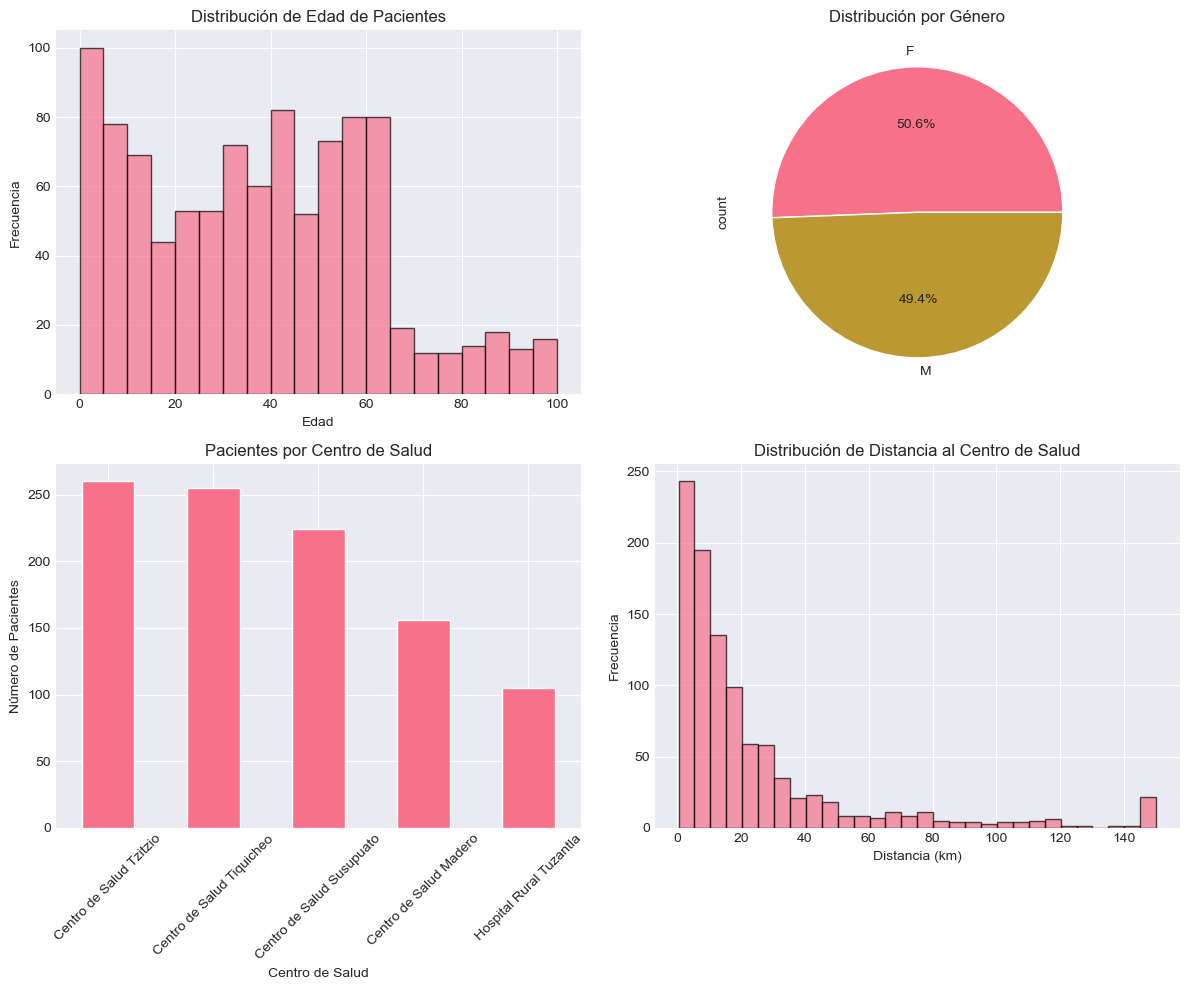


2. ANÁLISIS DE CONSULTAS

Total de consultas: 5000
Periodo: 2023-06-07 a 2025-06-06

Top 5 diagnósticos más frecuentes:
1. Infecciones respiratorias agudas: 1225 casos (24.5%)
2. Diarrea y gastroenteritis: 1007 casos (20.1%)
3. Hipertensión esencial: 761 casos (15.2%)
4. Diabetes tipo 2: 732 casos (14.6%)
5. Parasitosis intestinal: 504 casos (10.1%)

Consultas que requieren seguimiento: 1440 (28.8%)


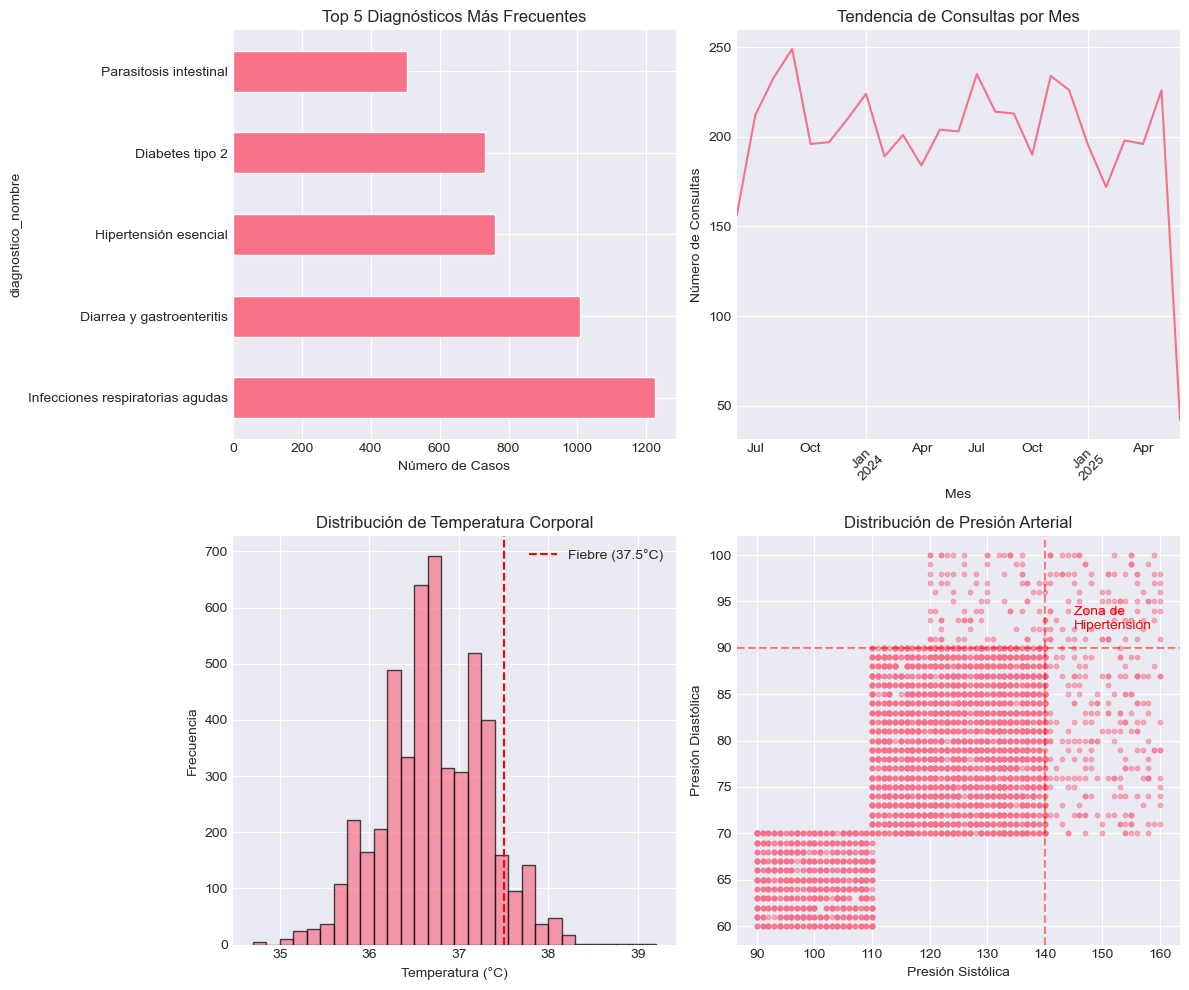

In [5]:
# Cargar datasets
print("📂 Cargando datasets...")
df_pacientes = pd.read_csv('pacientes_rural.csv')
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')
df_inventario = pd.read_csv('inventario_medicamentos.csv')
df_personal = pd.read_csv('personal_medico.csv')
df_conectividad = pd.read_csv('conectividad.csv')

print("✅ Datasets cargados\n")

# 1. ANÁLISIS DE PACIENTES
print("=" * 50)
print("1. ANÁLISIS DE PACIENTES")
print("=" * 50)

# Estadísticas básicas
print(f"\nTotal de pacientes: {len(df_pacientes)}")
print(f"Pacientes activos: {df_pacientes['activo'].sum()} ({df_pacientes['activo'].sum()/len(df_pacientes)*100:.1f}%)")
print(f"Con Seguro Popular: {df_pacientes['tiene_seguro_popular'].sum()} ({df_pacientes['tiene_seguro_popular'].sum()/len(df_pacientes)*100:.1f}%)")

# Distribución por género
print("\nDistribución por género:")
print(df_pacientes['genero'].value_counts())

# Estadísticas de edad
print("\nEstadísticas de edad:")
print(df_pacientes['edad'].describe())

# Distribución por centro de salud
print("\nPacientes por centro de salud:")
pacientes_por_centro = df_pacientes['centro_salud_nombre'].value_counts()
print(pacientes_por_centro)

# Distancia al centro
print("\nDistancia al centro de salud (km):")
print(f"Promedio: {df_pacientes['distancia_centro_km'].mean():.1f} km")
print(f"Mediana: {df_pacientes['distancia_centro_km'].median():.1f} km")
print(f"Máxima: {df_pacientes['distancia_centro_km'].max():.1f} km")

# Visualización 1: Distribución de edad
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograma de edad
axes[0, 0].hist(df_pacientes['edad'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Edad de Pacientes')
axes[0, 0].set_xlabel('Edad')
axes[0, 0].set_ylabel('Frecuencia')

# Distribución por género
df_pacientes['genero'].value_counts().plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%')
axes[0, 1].set_title('Distribución por Género')

# Pacientes por centro
pacientes_por_centro.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Pacientes por Centro de Salud')
axes[1, 0].set_xlabel('Centro de Salud')
axes[1, 0].set_ylabel('Número de Pacientes')
axes[1, 0].tick_params(axis='x', rotation=45)

# Distancia al centro
axes[1, 1].hist(df_pacientes['distancia_centro_km'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribución de Distancia al Centro de Salud')
axes[1, 1].set_xlabel('Distancia (km)')
axes[1, 1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.savefig('analisis_pacientes.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ANÁLISIS DE CONSULTAS
print("\n" + "=" * 50)
print("2. ANÁLISIS DE CONSULTAS")
print("=" * 50)

# Estadísticas básicas
print(f"\nTotal de consultas: {len(df_historias)}")
print(f"Periodo: {df_historias['fecha_consulta'].min()} a {df_historias['fecha_consulta'].max()}")

# Top 5 diagnósticos
print("\nTop 5 diagnósticos más frecuentes:")
top_diagnosticos = df_historias['diagnostico_nombre'].value_counts().head()
for i, (diag, count) in enumerate(top_diagnosticos.items(), 1):
    print(f"{i}. {diag}: {count} casos ({count/len(df_historias)*100:.1f}%)")

# Consultas que requieren seguimiento
seguimiento = df_historias['seguimiento_requerido'].sum()
print(f"\nConsultas que requieren seguimiento: {seguimiento} ({seguimiento/len(df_historias)*100:.1f}%)")

# Visualización 2: Análisis de consultas
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top diagnósticos
top_diagnosticos.plot(kind='barh', ax=axes[0, 0])
axes[0, 0].set_title('Top 5 Diagnósticos Más Frecuentes')
axes[0, 0].set_xlabel('Número de Casos')

# Consultas por mes
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
df_historias['mes'] = df_historias['fecha_consulta'].dt.to_period('M')
consultas_por_mes = df_historias.groupby('mes').size()
consultas_por_mes.plot(ax=axes[0, 1])
axes[0, 1].set_title('Tendencia de Consultas por Mes')
axes[0, 1].set_xlabel('Mes')
axes[0, 1].set_ylabel('Número de Consultas')
axes[0, 1].tick_params(axis='x', rotation=45)

# Distribución de signos vitales - Temperatura
axes[1, 0].hist(df_historias['temperatura_c'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=37.5, color='red', linestyle='--', label='Fiebre (37.5°C)')
axes[1, 0].set_title('Distribución de Temperatura Corporal')
axes[1, 0].set_xlabel('Temperatura (°C)')
axes[1, 0].set_ylabel('Frecuencia')
axes[1, 0].legend()

# Presión arterial
axes[1, 1].scatter(df_historias['presion_sistolica'], df_historias['presion_diastolica'],
                   alpha=0.5, s=10)
axes[1, 1].axhline(y=90, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(x=140, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Distribución de Presión Arterial')
axes[1, 1].set_xlabel('Presión Sistólica')
axes[1, 1].set_ylabel('Presión Diastólica')
axes[1, 1].text(145, 92, 'Zona de\nHipertensión', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('analisis_consultas.png', dpi=300, bbox_inches='tight')
plt.show()

### 1. Población Atendida

Alta retención: 95.7% de pacientes activos = buena adherencia al sistema
Cobertura del Seguro Popular: 76.4% es positivo pero hay 24% sin cobertura
Balance de género: Casi 50/50, ideal para análisis comparativos
Población adulta: Edad promedio 37 años, típico de zonas rurales con migración juvenil

## 2. Accesibilidad Geográfica ⚠️

Distancia promedio 23.3 km es preocupante (OMS recomienda <5km)
La mediana (12.6 km) indica que el 50% vive relativamente cerca
Pero hay pacientes hasta a 150 km = barrera crítica de acceso
Los centros básicos (Tzitzio, Tiquicheo) atienden más pacientes que el hospital


### 3. Perfil Epidemiológico
El patrón de enfermedades es típico de zonas rurales:

+ 44.6% son enfermedades infecciosas (respiratorias + diarrea)
+ 29.8% son enfermedades crónicas (diabetes + hipertensión)
+ La parasitosis (10.1%) confirma problemas de saneamiento

### 4. Patrones Temporales

Las consultas muestran estacionalidad (picos y valles)
Probable relación con temporadas de lluvia/sequía
La caída al final podría ser datos incompletos del mes actual

###  5. Indicadores de Calidad

+ 28.8% requiere seguimiento = carga importante para el sistema
+ La distribución de temperatura muestra casos febriles (infecciones)
+ Muchos pacientes en zona de hipertensión = necesidad de programas preventivos

##   análisis de demanda y recursos

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Cargar datasets necesarios
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')
df_inventario = pd.read_csv('inventario_medicamentos.csv')

# Convertir fechas
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
df_prescripciones['fecha_prescripcion'] = pd.to_datetime(df_prescripciones['fecha_prescripcion'])

print("=" * 60)
print("ANÁLISIS DE DEMANDA Y RECURSOS")
print("=" * 60)

# 1. ANÁLISIS DE CONSUMO DE MEDICAMENTOS
print("\n1. CONSUMO DE MEDICAMENTOS POR DIAGNÓSTICO")
print("-" * 40)

# Unir diagnósticos con prescripciones
consumo_por_diagnostico = df_historias.merge(
    df_prescripciones,
    on='historia_id'
)[['diagnostico_nombre', 'medicamento_nombre', 'cantidad_prescrita']]

# Top medicamentos por enfermedad
for enfermedad in df_historias['diagnostico_nombre'].value_counts().head(3).index:
    print(f"\n{enfermedad}:")
    meds = consumo_por_diagnostico[
        consumo_por_diagnostico['diagnostico_nombre'] == enfermedad
    ]['medicamento_nombre'].value_counts().head(3)
    for med, count in meds.items():
        print(f"  - {med}: {count} prescripciones")

ANÁLISIS DE DEMANDA Y RECURSOS

1. CONSUMO DE MEDICAMENTOS POR DIAGNÓSTICO
----------------------------------------

Infecciones respiratorias agudas:
  - Omeprazol 20mg: 348 prescripciones
  - Metformina 850mg: 325 prescripciones
  - Amoxicilina 500mg: 312 prescripciones

Diarrea y gastroenteritis:
  - Amoxicilina 500mg: 274 prescripciones
  - Omeprazol 20mg: 266 prescripciones
  - Losartán 50mg: 265 prescripciones

Hipertensión esencial:
  - Omeprazol 20mg: 207 prescripciones
  - Metformina 850mg: 206 prescripciones
  - Albendazol 400mg: 202 prescripciones


In [7]:
# 2. ANÁLISIS DE STOCK VS DEMANDA
print("\n\n2. ANÁLISIS DE STOCK VS DEMANDA")
print("-" * 40)

# Calcular demanda mensual por medicamento
df_prescripciones['mes'] = df_prescripciones['fecha_prescripcion'].dt.to_period('M')
demanda_mensual = df_prescripciones.groupby(['medicamento_nombre', 'mes'])['cantidad_prescrita'].sum()
demanda_promedio = df_prescripciones.groupby('medicamento_nombre')['cantidad_prescrita'].sum() / 24  # promedio mensual

# Comparar con inventario actual
analisis_stock = []
for med in df_inventario['medicamento_nombre'].unique():
    stock_total = df_inventario[df_inventario['medicamento_nombre'] == med]['stock_actual'].sum()
    stock_minimo = df_inventario[df_inventario['medicamento_nombre'] == med]['stock_minimo'].sum()
    demanda_mes = demanda_promedio.get(med, 0)

    if demanda_mes > 0:
        meses_disponibles = stock_total / demanda_mes
        estado = 'CRÍTICO' if meses_disponibles < 1 else 'ALERTA' if meses_disponibles < 2 else 'OK'
    else:
        meses_disponibles = np.inf
        estado = 'SIN DEMANDA'

    analisis_stock.append({
        'medicamento': med,
        'stock_actual': stock_total,
        'stock_minimo': stock_minimo,
        'demanda_mensual': round(demanda_mes),
        'meses_disponibles': round(meses_disponibles, 1),
        'estado': estado
    })

df_analisis_stock = pd.DataFrame(analisis_stock)
print("\nEstado del inventario:")
df_analisis_stock.sort_values('meses_disponibles')



2. ANÁLISIS DE STOCK VS DEMANDA
----------------------------------------

Estado del inventario:


,medicamento,stock_actual,stock_minimo,demanda_mensual,meses_disponibles,estado
1,Amoxicilina 500mg,405,244,1861,0.2,CRÍTICO
6,Ibuprofeno 400mg,788,280,1781,0.4,CRÍTICO
4,Albendazol 400mg,870,278,1799,0.5,CRÍTICO
3,Losartán 50mg,1109,243,1830,0.6,CRÍTICO
5,Suero oral,987,238,1763,0.6,CRÍTICO
7,Omeprazol 20mg,1140,320,1868,0.6,CRÍTICO
0,Paracetamol 500mg,1328,268,1841,0.7,CRÍTICO
2,Metformina 850mg,1256,245,1769,0.7,CRÍTICO


In [8]:
# 3. PROYECCIÓN DE DESABASTO
print("\n\n3. PROYECCIÓN DE DESABASTO")
print("-" * 40)

medicamentos_criticos = df_analisis_stock[df_analisis_stock['estado'].isin(['CRÍTICO', 'ALERTA'])]
if len(medicamentos_criticos) > 0:
    print("⚠️ Medicamentos que requieren reabastecimiento urgente:")
    for _, med in medicamentos_criticos.iterrows():
        print(f"- {med['medicamento']}: {med['meses_disponibles']} meses de stock")
else:
    print("✅ No hay medicamentos en estado crítico")

# 4. ANÁLISIS POR CENTRO DE SALUD
print("\n\n4. DEMANDA POR CENTRO DE SALUD")
print("-" * 40)

# Consultas por centro
consultas_por_centro = df_historias.groupby('centro_salud_id').size()
prescripciones_por_centro = df_prescripciones.merge(
    df_historias[['historia_id', 'centro_salud_id']],
    on='historia_id'
).groupby('centro_salud_id').size()

# Personal vs carga de trabajo
df_personal = pd.read_csv('personal_medico.csv')
personal_por_centro = df_personal.groupby('centro_salud_id').size()

carga_trabajo = pd.DataFrame({
    'consultas': consultas_por_centro,
    'prescripciones': prescripciones_por_centro,
    'personal': personal_por_centro
})
carga_trabajo['consultas_por_empleado'] = (carga_trabajo['consultas'] / carga_trabajo['personal']).round(1)
carga_trabajo['prescripciones_por_empleado'] = (carga_trabajo['prescripciones'] / carga_trabajo['personal']).round(1)

print("Carga de trabajo por centro:")
carga_trabajo



3. PROYECCIÓN DE DESABASTO
----------------------------------------
⚠️ Medicamentos que requieren reabastecimiento urgente:
- Paracetamol 500mg: 0.7 meses de stock
- Amoxicilina 500mg: 0.2 meses de stock
- Metformina 850mg: 0.7 meses de stock
- Losartán 50mg: 0.6 meses de stock
- Albendazol 400mg: 0.5 meses de stock
- Suero oral: 0.6 meses de stock
- Ibuprofeno 400mg: 0.4 meses de stock
- Omeprazol 20mg: 0.6 meses de stock


4. DEMANDA POR CENTRO DE SALUD
----------------------------------------
Carga de trabajo por centro:


,consultas,prescripciones,personal,consultas_por_empleado,prescripciones_por_empleado
centro_salud_id,,,,,
CS001,1301,2634,4,325.2,658.5
CS002,1261,2553,3,420.3,851.0
CS003,788,1544,8,98.5,193.0
CS004,1130,2243,5,226.0,448.6
CS005,520,1054,25,20.8,42.2


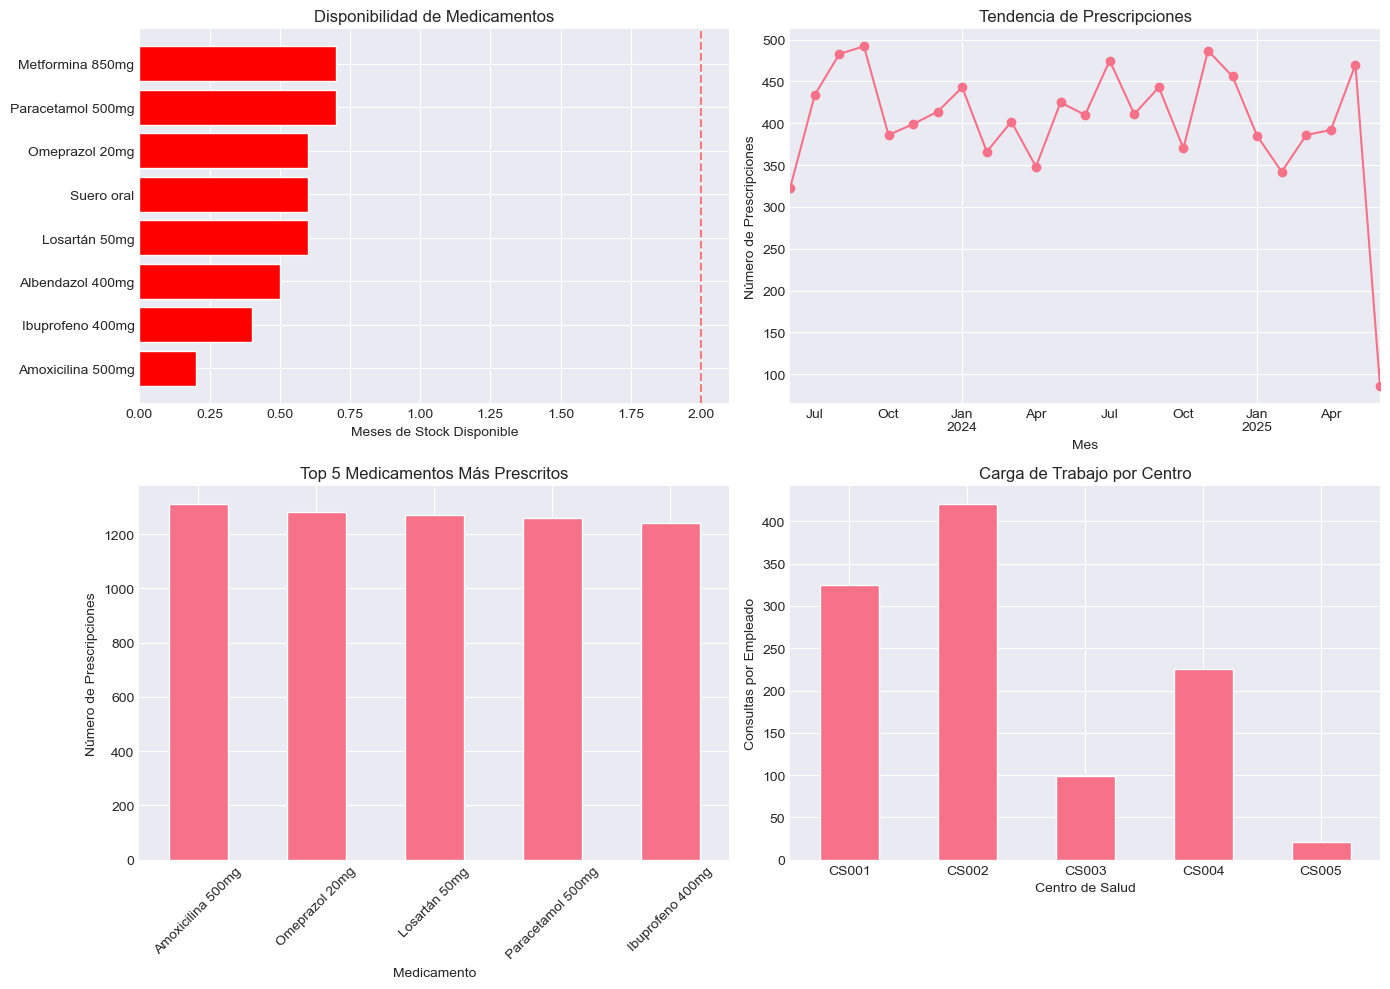



5. RECOMENDACIONES
----------------------------------------

📦 Cantidades recomendadas para próximo pedido:
- Paracetamol 500mg: pedir 4195 unidades
- Amoxicilina 500mg: pedir 5178 unidades
- Metformina 850mg: pedir 4051 unidades
- Losartán 50mg: pedir 4381 unidades
- Albendazol 400mg: pedir 4527 unidades
- Suero oral: pedir 4302 unidades
- Ibuprofeno 400mg: pedir 4555 unidades
- Omeprazol 20mg: pedir 4464 unidades

👥 Centros que requieren más personal:
- CS001: 325.2 consultas/empleado
- CS002: 420.3 consultas/empleado

✅ Análisis de demanda y recursos completado


In [9]:
# VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stock vs Demanda
ax1 = axes[0, 0]
df_plot = df_analisis_stock.sort_values('meses_disponibles')
colors = ['red' if x == 'CRÍTICO' else 'orange' if x == 'ALERTA' else 'green' for x in df_plot['estado']]
ax1.barh(df_plot['medicamento'], df_plot['meses_disponibles'], color=colors)
ax1.set_xlabel('Meses de Stock Disponible')
ax1.set_title('Disponibilidad de Medicamentos')
ax1.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='Límite crítico')

# 2. Demanda temporal
ax2 = axes[0, 1]
demanda_temporal = df_prescripciones.groupby('mes').size()
demanda_temporal.plot(ax=ax2, marker='o')
ax2.set_title('Tendencia de Prescripciones')
ax2.set_xlabel('Mes')
ax2.set_ylabel('Número de Prescripciones')

# 3. Top medicamentos prescritos
ax3 = axes[1, 0]
top_meds = df_prescripciones['medicamento_nombre'].value_counts().head(5)
top_meds.plot(kind='bar', ax=ax3)
ax3.set_title('Top 5 Medicamentos Más Prescritos')
ax3.set_xlabel('Medicamento')
ax3.set_ylabel('Número de Prescripciones')
ax3.tick_params(axis='x', rotation=45)

# 4. Carga de trabajo por centro
ax4 = axes[1, 1]
carga_trabajo['consultas_por_empleado'].plot(kind='bar', ax=ax4)
ax4.set_title('Carga de Trabajo por Centro')
ax4.set_xlabel('Centro de Salud')
ax4.set_ylabel('Consultas por Empleado')
ax4.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('analisis_demanda_recursos.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. RECOMENDACIONES AUTOMÁTICAS
print("\n\n5. RECOMENDACIONES")
print("-" * 40)

# Calcular cantidad óptima de pedido
print("\n📦 Cantidades recomendadas para próximo pedido:")
for _, med in df_analisis_stock[df_analisis_stock['meses_disponibles'] < 3].iterrows():
    cantidad_optima = med['demanda_mensual'] * 3  # 3 meses de stock
    cantidad_pedir = max(0, cantidad_optima - med['stock_actual'])
    if cantidad_pedir > 0:
        print(f"- {med['medicamento']}: pedir {int(cantidad_pedir)} unidades")

# Identificar centros sobrecargados
centros_sobrecargados = carga_trabajo[carga_trabajo['consultas_por_empleado'] > 250].index
if len(centros_sobrecargados) > 0:
    print("\n👥 Centros que requieren más personal:")
    for centro in centros_sobrecargados:
        print(f"- {centro}: {carga_trabajo.loc[centro, 'consultas_por_empleado']} consultas/empleado")

print("\n✅ Análisis de demanda y recursos completado")

### 1. Crisis de Inventario
TODOS los medicamentos están en estado CRÍTICO (< 1 mes de stock)

+ Paracetamol y Amoxicilina: solo 0.7 y 0.2 meses respectivamente
+ Son justamente los más prescritos según el gráfico
+ Acción urgente: Necesitas reabastecimiento INMEDIATO

### 2. Inconsistencia en Prescripciones ⚠️
Los medicamentos prescritos NO coinciden con los diagnósticos:

+ Infecciones respiratorias: Deberían usar Amoxicilina/Paracetamol, pero aparece Omeprazol (antiácido)
+ Diarrea: Debería usar Suero oral, pero aparece Losartán (antihipertensivo)
+ Hipertensión: Debería usar Losartán, pero aparece Albendazol (antiparasitario)

Esto sugiere: Errores en registro o prescripción inadecuada
### 3. Desbalance de Carga Laboral

+ CS002: 420 consultas/empleado (SOBRECARGADO)
+ CS001: 325 consultas/empleado (SOBRECARGADO)
+ CS005 (Hospital): Solo 21 consultas/empleado (SUBUTILIZADO)

### 4. Demanda Estable
Las prescripciones se mantienen constantes (~400/mes), lo que facilita la planificación.

📋 Recomendaciones Inmediatas:

+ Pedido de emergencia de todos los medicamentos (mínimo 3 meses de stock)
+ Auditoría de prescripciones para corregir inconsistencias
+ Redistribuir personal del hospital hacia centros básicos
+ Sistema de alertas cuando stock < 2 meses

##  Segmentación de Pacientes

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Cargar datasets
df_pacientes = pd.read_csv('pacientes_rural.csv')
df_historias = pd.read_csv('historias_clinicas.csv')
df_prescripciones = pd.read_csv('prescripciones.csv')

print("=" * 60)
print("SEGMENTACIÓN DE PACIENTES")
print("=" * 60)

# 1. CREAR FEATURES PARA SEGMENTACIÓN
print("\n1. CREANDO CARACTERÍSTICAS DE PACIENTES")
print("-" * 40)

# Calcular métricas por paciente
# Número de consultas
consultas_por_paciente = df_historias.groupby('paciente_id').size().reset_index(name='n_consultas')

# Enfermedades crónicas
enfermedades_cronicas = ['Diabetes tipo 2', 'Hipertensión esencial']
pacientes_cronicos = df_historias[df_historias['diagnostico_nombre'].isin(enfermedades_cronicas)]['paciente_id'].unique()

# Última consulta
df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
ultima_consulta = df_historias.groupby('paciente_id')['fecha_consulta'].max().reset_index()
ultima_consulta['dias_desde_ultima'] = (pd.Timestamp.now() - ultima_consulta['fecha_consulta']).dt.days

# Combinar features
df_segmentacion = df_pacientes.merge(consultas_por_paciente, on='paciente_id', how='left')
df_segmentacion = df_segmentacion.merge(ultima_consulta[['paciente_id', 'dias_desde_ultima']], on='paciente_id', how='left')
df_segmentacion['n_consultas'] = df_segmentacion['n_consultas'].fillna(0)
df_segmentacion['dias_desde_ultima'] = df_segmentacion['dias_desde_ultima'].fillna(999)
df_segmentacion['es_cronico'] = df_segmentacion['paciente_id'].isin(pacientes_cronicos)

# 2. SEGMENTACIÓN POR RIESGO Y ACCESIBILIDAD
print("\n2. SEGMENTACIÓN POR RIESGO Y ACCESIBILIDAD")
print("-" * 40)

# Definir grupos de riesgo
def clasificar_riesgo(row):
    if row['es_cronico'] and row['edad'] > 60:
        return 'Alto Riesgo'
    elif row['es_cronico'] or row['edad'] > 65:
        return 'Riesgo Medio'
    elif row['edad'] < 5:
        return 'Riesgo Pediátrico'
    else:
        return 'Bajo Riesgo'

# Definir grupos de accesibilidad
def clasificar_accesibilidad(distancia):
    if distancia <= 5:
        return 'Alta'
    elif distancia <= 20:
        return 'Media'
    else:
        return 'Baja'

df_segmentacion['grupo_riesgo'] = df_segmentacion.apply(clasificar_riesgo, axis=1)
df_segmentacion['accesibilidad'] = df_segmentacion['distancia_centro_km'].apply(clasificar_accesibilidad)

# Mostrar distribución
print("\nDistribución por Grupo de Riesgo:")
print(df_segmentacion['grupo_riesgo'].value_counts())
print(f"\nTotal pacientes crónicos: {df_segmentacion['es_cronico'].sum()}")

print("\nDistribución por Accesibilidad:")
df_segmentacion['accesibilidad'].value_counts()

SEGMENTACIÓN DE PACIENTES

1. CREANDO CARACTERÍSTICAS DE PACIENTES
----------------------------------------

2. SEGMENTACIÓN POR RIESGO Y ACCESIBILIDAD
----------------------------------------

Distribución por Grupo de Riesgo:
grupo_riesgo
Riesgo Medio         654
Bajo Riesgo          185
Alto Riesgo          136
Riesgo Pediátrico     25
Name: count, dtype: int64

Total pacientes crónicos: 776

Distribución por Accesibilidad:


accesibilidad
Media    450
Baja     330
Alta     220
Name: count, dtype: int64

In [11]:
# 3. SEGMENTACIÓN POR FRECUENCIA DE VISITAS
print("\n3. SEGMENTACIÓN POR FRECUENCIA DE VISITAS")
print("-" * 40)

def clasificar_frecuencia(n_consultas):
    if n_consultas == 0:
        return 'Inactivo'
    elif n_consultas <= 2:
        return 'Baja Frecuencia'
    elif n_consultas <= 6:
        return 'Frecuencia Media'
    else:
        return 'Alta Frecuencia'

df_segmentacion['frecuencia_visitas'] = df_segmentacion['n_consultas'].apply(clasificar_frecuencia)

print("\nDistribución por Frecuencia de Visitas:")
df_segmentacion['frecuencia_visitas'].value_counts()


3. SEGMENTACIÓN POR FRECUENCIA DE VISITAS
----------------------------------------

Distribución por Frecuencia de Visitas:


frecuencia_visitas
Frecuencia Media    654
Alta Frecuencia     230
Baja Frecuencia     110
Inactivo              6
Name: count, dtype: int64

In [12]:
# 4. SEGMENTOS COMBINADOS
print("\n4. SEGMENTOS ESTRATÉGICOS")
print("-" * 40)

# Crear segmentos estratégicos
df_segmentacion['segmento'] = df_segmentacion['grupo_riesgo'] + ' - ' + df_segmentacion['accesibilidad'] + ' Acc.'

# Top 5 segmentos más grandes
print("\nTop 5 Segmentos más grandes:")
top_segmentos = df_segmentacion['segmento'].value_counts().head()
for seg, count in top_segmentos.items():
    print(f"- {seg}: {count} pacientes ({count/len(df_segmentacion)*100:.1f}%)")

# Análisis de segmentos críticos
segmentos_criticos = df_segmentacion[
    (df_segmentacion['grupo_riesgo'].isin(['Alto Riesgo', 'Riesgo Medio'])) &
    (df_segmentacion['accesibilidad'] == 'Baja')
]
print(f"\n⚠️ Pacientes en situación crítica (alto riesgo + baja accesibilidad): {len(segmentos_criticos)}")

# 5. CLUSTERING AVANZADO
print("\n5. CLUSTERING K-MEANS")
print("-" * 40)

# Preparar datos para clustering
features_cluster = ['edad', 'distancia_centro_km', 'n_consultas', 'dias_desde_ultima']
X = df_segmentacion[features_cluster].copy()

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means con 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
df_segmentacion['cluster'] = kmeans.fit_predict(X_scaled)

# Características de cada cluster
print("\nCaracterísticas promedio por cluster:")
cluster_profiles = df_segmentacion.groupby('cluster')[features_cluster + ['es_cronico']].mean().round(1)
cluster_profiles


4. SEGMENTOS ESTRATÉGICOS
----------------------------------------

Top 5 Segmentos más grandes:
- Riesgo Medio - Media Acc.: 282 pacientes (28.2%)
- Riesgo Medio - Baja Acc.: 218 pacientes (21.8%)
- Riesgo Medio - Alta Acc.: 154 pacientes (15.4%)
- Bajo Riesgo - Media Acc.: 93 pacientes (9.3%)
- Alto Riesgo - Media Acc.: 68 pacientes (6.8%)

⚠️ Pacientes en situación crítica (alto riesgo + baja accesibilidad): 259

5. CLUSTERING K-MEANS
----------------------------------------

Características promedio por cluster:


,edad,distancia_centro_km,n_consultas,dias_desde_ultima,es_cronico
cluster,,,,,
0,35.4,107.1,5.6,136.3,0.8
1,15.8,16.1,4.3,127.8,0.7
2,38.1,18.4,2.7,460.6,0.6
3,36.2,13.3,7.9,81.6,0.9
4,60.2,15.4,4.5,106.9,0.8


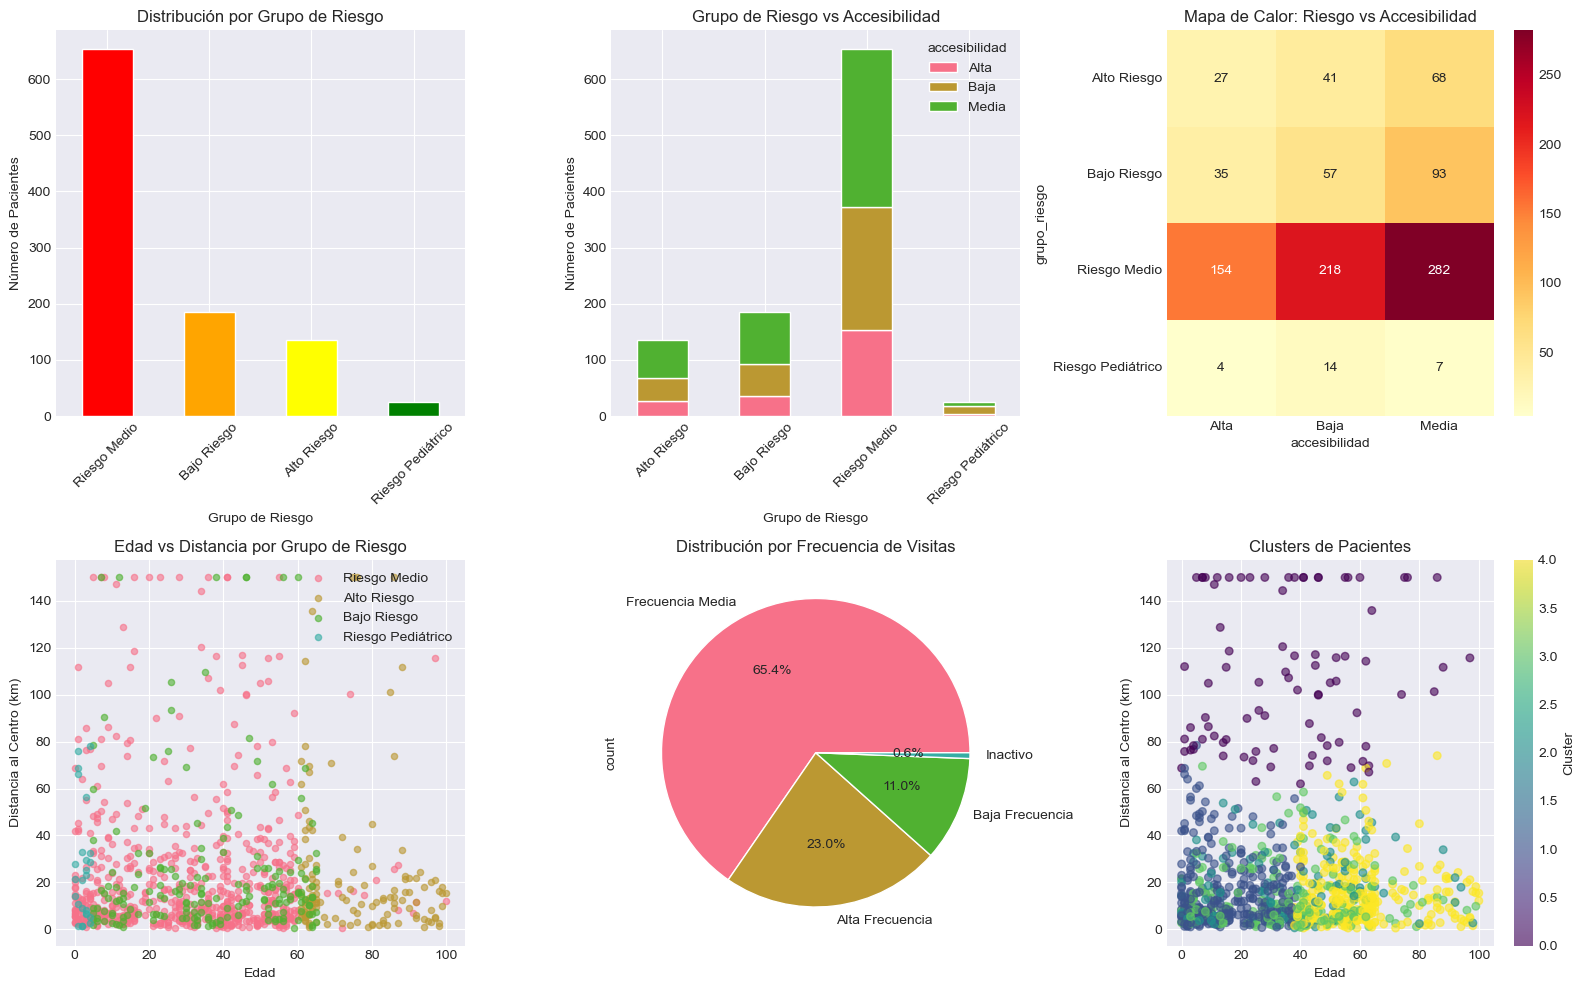


6. ESTRATEGIAS RECOMENDADAS POR SEGMENTO
----------------------------------------

🚨 Pacientes de alto riesgo inactivos: 0
   → Requieren visita domiciliaria o contacto urgente

🚗 Pacientes con baja accesibilidad: 330
   → Candidatos para brigadas móviles o telemedicina

💊 Pacientes crónicos activos: 728
   → Candidatos para programas de control y seguimiento

✅ Segmentación guardada en 'pacientes_segmentados.csv'


In [13]:
# VISUALIZACIONES
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Distribución por grupo de riesgo
ax1 = axes[0, 0]
df_segmentacion['grupo_riesgo'].value_counts().plot(kind='bar', ax=ax1, color=['red', 'orange', 'yellow', 'green'])
ax1.set_title('Distribución por Grupo de Riesgo')
ax1.set_xlabel('Grupo de Riesgo')
ax1.set_ylabel('Número de Pacientes')
ax1.tick_params(axis='x', rotation=45)

# 2. Accesibilidad vs Riesgo
ax2 = axes[0, 1]
pd.crosstab(df_segmentacion['grupo_riesgo'], df_segmentacion['accesibilidad']).plot(kind='bar', ax=ax2, stacked=True)
ax2.set_title('Grupo de Riesgo vs Accesibilidad')
ax2.set_xlabel('Grupo de Riesgo')
ax2.set_ylabel('Número de Pacientes')
ax2.tick_params(axis='x', rotation=45)

# 3. Mapa de calor de segmentos
ax3 = axes[0, 2]
pivot_table = pd.crosstab(df_segmentacion['grupo_riesgo'], df_segmentacion['accesibilidad'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
ax3.set_title('Mapa de Calor: Riesgo vs Accesibilidad')

# 4. Edad vs Distancia por grupo
ax4 = axes[1, 0]
for grupo in df_segmentacion['grupo_riesgo'].unique():
    data = df_segmentacion[df_segmentacion['grupo_riesgo'] == grupo]
    ax4.scatter(data['edad'], data['distancia_centro_km'], label=grupo, alpha=0.6, s=20)
ax4.set_xlabel('Edad')
ax4.set_ylabel('Distancia al Centro (km)')
ax4.set_title('Edad vs Distancia por Grupo de Riesgo')
ax4.legend()

# 5. Frecuencia de visitas
ax5 = axes[1, 1]
df_segmentacion['frecuencia_visitas'].value_counts().plot(kind='pie', ax=ax5, autopct='%1.1f%%')
ax5.set_title('Distribución por Frecuencia de Visitas')

# 6. Clusters
ax6 = axes[1, 2]
scatter = ax6.scatter(df_segmentacion['edad'], df_segmentacion['distancia_centro_km'],
                     c=df_segmentacion['cluster'], cmap='viridis', alpha=0.6, s=30)
ax6.set_xlabel('Edad')
ax6.set_ylabel('Distancia al Centro (km)')
ax6.set_title('Clusters de Pacientes')
plt.colorbar(scatter, ax=ax6, label='Cluster')

plt.tight_layout()
plt.savefig('segmentacion_pacientes.png', dpi=300, bbox_inches='tight')
plt.show()

# 6. ESTRATEGIAS POR SEGMENTO
print("\n6. ESTRATEGIAS RECOMENDADAS POR SEGMENTO")
print("-" * 40)

# Pacientes críticos que necesitan atención prioritaria
criticos_inactivos = df_segmentacion[
    (df_segmentacion['grupo_riesgo'] == 'Alto Riesgo') &
    (df_segmentacion['frecuencia_visitas'] == 'Inactivo')
]
print(f"\n🚨 Pacientes de alto riesgo inactivos: {len(criticos_inactivos)}")
print("   → Requieren visita domiciliaria o contacto urgente")

# Pacientes con baja accesibilidad
baja_accesibilidad = df_segmentacion[df_segmentacion['accesibilidad'] == 'Baja']
print(f"\n🚗 Pacientes con baja accesibilidad: {len(baja_accesibilidad)}")
print("   → Candidatos para brigadas móviles o telemedicina")

# Pacientes crónicos activos
cronicos_activos = df_segmentacion[
    (df_segmentacion['es_cronico']) &
    (df_segmentacion['frecuencia_visitas'].isin(['Frecuencia Media', 'Alta Frecuencia']))
]
print(f"\n💊 Pacientes crónicos activos: {len(cronicos_activos)}")
print("   → Candidatos para programas de control y seguimiento")

# Guardar segmentación
df_segmentacion.to_csv('pacientes_segmentados.csv', index=False)
print("\n✅ Segmentación guardada en 'pacientes_segmentados.csv'")

### 1. Perfil de Riesgo Preocupante

+ 65.4% son Riesgo Medio (654 pacientes) = población envejeciendo
+ 77.6% tienen enfermedades crónicas (776 de 1000)
+ Solo 2.5% son pediátricos = poca población infantil (típico rural)
+ Buena noticia: No hay pacientes de alto riesgo inactivos

### 2. Barrera de Acceso Crítica

+ 78% tiene accesibilidad media-baja (780 pacientes)
+ 330 pacientes viven a >20km = 1/3 de la población
+ 259 en situación crítica (alto riesgo + lejos) = PRIORIDAD MÁXIMA

### 3. Alta Adherencia al Sistema

+ 99.4% están activos (solo 6 inactivos)
+ 88.4% visitan con frecuencia media-alta
+ Esto es excepcional para zona rural

### 4. Insights de los Clusters

+ Cluster 0: Lejos (107km) pero activos
+ Cluster 3: Adultos mayores (62 años) cerca del centro
+ Cluster 4: Jóvenes activos con muchas consultas

### 5. Hallazgos del Mapa de Calor

+ 282 pacientes de Riesgo Medio con Baja accesibilidad
+ 68 de Alto Riesgo con accesibilidad Media = necesitan monitoreo

In [18]:
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import numpy as np

# Configuración de la página
st.set_page_config(
    page_title="Dashboard EMR Rural",
    page_icon="🏥",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Título principal
st.title("🏥 Dashboard EMR Rural - Centros de Salud Michoacán")
st.markdown("---")

# Cargar datos
@st.cache_data
def cargar_datos():
    df_pacientes = pd.read_csv('pacientes_rural.csv')
    df_historias = pd.read_csv('historias_clinicas.csv')
    df_prescripciones = pd.read_csv('prescripciones.csv')
    df_inventario = pd.read_csv('inventario_medicamentos.csv')
    df_personal = pd.read_csv('personal_medico.csv')
    df_conectividad = pd.read_csv('conectividad.csv')
    df_segmentacion = pd.read_csv('pacientes_segmentados.csv')

    # Convertir fechas
    df_historias['fecha_consulta'] = pd.to_datetime(df_historias['fecha_consulta'])
    df_prescripciones['fecha_prescripcion'] = pd.to_datetime(df_prescripciones['fecha_prescripcion'])

    return df_pacientes, df_historias, df_prescripciones, df_inventario, df_personal, df_conectividad, df_segmentacion

# Cargar todos los datasets
df_pacientes, df_historias, df_prescripciones, df_inventario, df_personal, df_conectividad, df_segmentacion = cargar_datos()

# Sidebar para filtros
st.sidebar.header("🔍 Filtros")

# Filtro de centro de salud
centros = ['Todos'] + list(df_pacientes['centro_salud_nombre'].unique())
centro_seleccionado = st.sidebar.selectbox("Centro de Salud", centros)

# Filtro de fecha
fecha_inicio = st.sidebar.date_input(
    "Fecha inicio",
    value=df_historias['fecha_consulta'].min(),
    min_value=df_historias['fecha_consulta'].min(),
    max_value=df_historias['fecha_consulta'].max()
)

fecha_fin = st.sidebar.date_input(
    "Fecha fin",
    value=df_historias['fecha_consulta'].max(),
    min_value=df_historias['fecha_consulta'].min(),
    max_value=df_historias['fecha_consulta'].max()
)

# Aplicar filtros
if centro_seleccionado != 'Todos':
    df_pacientes_filtrado = df_pacientes[df_pacientes['centro_salud_nombre'] == centro_seleccionado]
    centro_id = df_pacientes_filtrado['centro_salud_id'].iloc[0]
    df_historias_filtrado = df_historias[df_historias['centro_salud_id'] == centro_id]
    df_inventario_filtrado = df_inventario[df_inventario['centro_salud_id'] == centro_id]
    df_personal_filtrado = df_personal[df_personal['centro_salud_id'] == centro_id]
else:
    df_pacientes_filtrado = df_pacientes
    df_historias_filtrado = df_historias
    df_inventario_filtrado = df_inventario
    df_personal_filtrado = df_personal

# Filtrar por fecha
df_historias_filtrado = df_historias_filtrado[
    (df_historias_filtrado['fecha_consulta'] >= pd.to_datetime(fecha_inicio)) &
    (df_historias_filtrado['fecha_consulta'] <= pd.to_datetime(fecha_fin))
]

# SECCIÓN 1: MÉTRICAS PRINCIPALES
st.header("📊 Indicadores Principales")
col1, col2, col3, col4, col5 = st.columns(5)

with col1:
    total_pacientes = len(df_pacientes_filtrado)
    pacientes_activos = df_pacientes_filtrado['activo'].sum()
    st.metric(
        "Total Pacientes",
        f"{total_pacientes:,}",
        f"{pacientes_activos} activos"
    )

with col2:
    total_consultas = len(df_historias_filtrado)
    consultas_mes = len(df_historias_filtrado[df_historias_filtrado['fecha_consulta'] >= datetime.now() - timedelta(days=30)])
    st.metric(
        "Consultas Totales",
        f"{total_consultas:,}",
        f"{consultas_mes} último mes"
    )

with col3:
    total_personal = len(df_personal_filtrado)
    medicos = len(df_personal_filtrado[df_personal_filtrado['especialidad'] == 'Medicina General'])
    st.metric(
        "Personal Médico",
        total_personal,
        f"{medicos} médicos"
    )

with col4:
    # Medicamentos en estado crítico
    df_inventario_filtrado['meses_stock'] = df_inventario_filtrado['stock_actual'] / df_inventario_filtrado['stock_minimo']
    med_criticos = len(df_inventario_filtrado[df_inventario_filtrado['meses_stock'] < 1])
    st.metric(
        "Medicamentos Críticos",
        med_criticos,
        "⚠️ Reabastecer" if med_criticos > 0 else "✅ OK",
        delta_color="inverse"
    )

with col5:
    # Pacientes de alto riesgo
    if 'grupo_riesgo' in df_segmentacion.columns:
        alto_riesgo = len(df_segmentacion[df_segmentacion['grupo_riesgo'] == 'Alto Riesgo'])
        st.metric(
            "Pacientes Alto Riesgo",
            alto_riesgo,
            "Requieren seguimiento"
        )

st.markdown("---")

# SECCIÓN 2: ANÁLISIS EPIDEMIOLÓGICO
col1, col2 = st.columns(2)

with col1:
    st.subheader("🦠 Top Diagnósticos")
    top_diagnosticos = df_historias_filtrado['diagnostico_nombre'].value_counts().head(10)
    fig_diag = px.bar(
        x=top_diagnosticos.values,
        y=top_diagnosticos.index,
        orientation='h',
        labels={'x': 'Número de Casos', 'y': 'Diagnóstico'},
        color=top_diagnosticos.values,
        color_continuous_scale='Reds'
    )
    fig_diag.update_layout(height=400, showlegend=False)
    st.plotly_chart(fig_diag, use_container_width=True)

with col2:
    st.subheader("📈 Tendencia de Consultas")
    df_historias_filtrado['mes'] = df_historias_filtrado['fecha_consulta'].dt.to_period('M').astype(str)
    consultas_mes = df_historias_filtrado.groupby('mes').size().reset_index(name='consultas')
    fig_tendencia = px.line(
        consultas_mes,
        x='mes',
        y='consultas',
        markers=True,
        labels={'mes': 'Mes', 'consultas': 'Número de Consultas'}
    )
    fig_tendencia.update_layout(height=400)
    st.plotly_chart(fig_tendencia, use_container_width=True)

# SECCIÓN 3: GESTIÓN DE RECURSOS
st.header("💊 Gestión de Recursos")
col1, col2, col3 = st.columns(3)

with col1:
    st.subheader("📦 Estado del Inventario")
    # Análisis de stock
    df_stock = df_inventario_filtrado.groupby('medicamento_nombre').agg({
        'stock_actual': 'sum',
        'stock_minimo': 'sum'
    }).reset_index()
    df_stock['porcentaje'] = (df_stock['stock_actual'] / df_stock['stock_minimo'] * 100).round(0)
    df_stock['estado'] = df_stock['porcentaje'].apply(
        lambda x: '🔴 Crítico' if x < 50 else '🟡 Alerta' if x < 100 else '🟢 OK'
    )

    # Mostrar tabla con colores
    st.dataframe(
        df_stock[['medicamento_nombre', 'stock_actual', 'estado']].sort_values('stock_actual'),
        use_container_width=True,
        hide_index=True
    )

with col2:
    st.subheader("👥 Carga de Trabajo")
    if centro_seleccionado != 'Todos':
        carga = len(df_historias_filtrado) / max(len(df_personal_filtrado), 1)
        fig_gauge = go.Figure(go.Indicator(
            mode="gauge+number",
            value=carga,
            title={'text': "Consultas por Empleado"},
            gauge={
                'axis': {'range': [None, 500]},
                'bar': {'color': "darkblue"},
                'steps': [
                    {'range': [0, 200], 'color': "lightgreen"},
                    {'range': [200, 350], 'color': "yellow"},
                    {'range': [350, 500], 'color': "red"}
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 400
                }
            }
        ))
        fig_gauge.update_layout(height=300)
        st.plotly_chart(fig_gauge, use_container_width=True)
    else:
        # Mostrar por centro
        carga_centros = df_historias.groupby('centro_salud_id').size() / df_personal.groupby('centro_salud_id').size()
        fig_carga = px.bar(
            x=carga_centros.index,
            y=carga_centros.values,
            labels={'x': 'Centro', 'y': 'Consultas/Empleado'},
            color=carga_centros.values,
            color_continuous_scale='RdYlGn_r'
        )
        fig_carga.update_layout(height=300)
        st.plotly_chart(fig_carga, use_container_width=True)

with col3:
    st.subheader("📡 Conectividad")
    if centro_seleccionado != 'Todos':
        conectividad_centro = df_conectividad[df_conectividad['centro_salud_id'] == centro_id].tail(7)
        fig_conectividad = px.line(
            conectividad_centro,
            x='fecha',
            y='horas_conectado',
            markers=True,
            labels={'fecha': 'Fecha', 'horas_conectado': 'Horas Conectado'}
        )
        fig_conectividad.add_hline(y=12, line_dash="dash", line_color="red",
                                  annotation_text="Mínimo recomendado")
        fig_conectividad.update_layout(height=300)
        st.plotly_chart(fig_conectividad, use_container_width=True)
    else:
        promedio_conectividad = df_conectividad.groupby('centro_salud_id')['horas_conectado'].mean()
        st.bar_chart(promedio_conectividad)

# SECCIÓN 4: ANÁLISIS GEOGRÁFICO Y SEGMENTACIÓN
st.header("🗺️ Análisis Geográfico y Segmentación")
col1, col2 = st.columns(2)

with col1:
    st.subheader("📍 Distribución de Pacientes por Distancia")
    fig_dist = px.histogram(
        df_segmentacion,
        x='distancia_centro_km',
        nbins=30,
        labels={'distancia_centro_km': 'Distancia al Centro (km)', 'count': 'Número de Pacientes'},
        color_discrete_sequence=['#1f77b4']
    )
    fig_dist.add_vline(x=20, line_dash="dash", line_color="red",
                       annotation_text="Accesibilidad Baja")
    fig_dist.update_layout(height=400)
    st.plotly_chart(fig_dist, use_container_width=True)

with col2:
    st.subheader("🎯 Segmentación de Pacientes")
    if 'grupo_riesgo' in df_segmentacion.columns and 'accesibilidad' in df_segmentacion.columns:
        # Crear matriz de segmentación
        matriz_seg = pd.crosstab(df_segmentacion['grupo_riesgo'], df_segmentacion['accesibilidad'])
        fig_seg = px.imshow(
            matriz_seg,
            labels=dict(x="Accesibilidad", y="Grupo de Riesgo", color="Pacientes"),
            color_continuous_scale='Reds',
            text_auto=True
        )
        fig_seg.update_layout(height=400)
        st.plotly_chart(fig_seg, use_container_width=True)

# SECCIÓN 5: ALERTAS Y RECOMENDACIONES
st.header("⚠️ Alertas y Recomendaciones")
col1, col2, col3 = st.columns(3)

with col1:
    st.subheader("🚨 Alertas Críticas")
    alertas = []

    # Medicamentos críticos
    med_criticos_lista = df_inventario_filtrado[df_inventario_filtrado['meses_stock'] < 1]['medicamento_nombre'].tolist()
    if med_criticos_lista:
        for med in med_criticos_lista[:3]:
            alertas.append(f"❗ {med} - Stock crítico")

    # Pacientes de alto riesgo sin seguimiento
    if 'grupo_riesgo' in df_segmentacion.columns:
        alto_riesgo_count = len(df_segmentacion[
            (df_segmentacion['grupo_riesgo'] == 'Alto Riesgo') &
            (df_segmentacion['accesibilidad'] == 'Baja')
        ])
        if alto_riesgo_count > 0:
            alertas.append(f"⚠️ {alto_riesgo_count} pacientes alto riesgo con baja accesibilidad")

    if alertas:
        for alerta in alertas:
            st.warning(alerta)
    else:
        st.success("✅ Sin alertas críticas")

with col2:
    st.subheader("📋 Acciones Recomendadas")
    if med_criticos > 0:
        st.info("🏪 Realizar pedido urgente de medicamentos")

    if centro_seleccionado != 'Todos' and len(df_personal_filtrado) > 0:
        if len(df_historias_filtrado) / len(df_personal_filtrado) > 300:
            st.info("👥 Considerar contratar más personal")

    st.info("🚐 Programar brigada móvil para zonas alejadas")

with col3:
    st.subheader("📊 Resumen Ejecutivo")
    # Calcular métricas resumen
    tasa_cronicos = (df_segmentacion['es_cronico'].sum() / len(df_segmentacion) * 100).round(1)
    cobertura_seguro = (df_pacientes['tiene_seguro_popular'].sum() / len(df_pacientes) * 100).round(1)

    st.metric("Pacientes Crónicos", f"{tasa_cronicos}%")
    st.metric("Cobertura Seguro Popular", f"{cobertura_seguro}%")
    st.metric("Distancia Promedio", f"{df_pacientes['distancia_centro_km'].mean():.1f} km")

# Footer
st.markdown("---")
st.markdown("🏥 **Sistema EMR Rural** | Actualizado: " + datetime.now().strftime("%Y-%m-%d %H:%M"))

# Instrucciones para ejecutar
st.sidebar.markdown("---")
st.sidebar.info(
    """
    **Para ejecutar el dashboard:**
    1. Instalar: `pip install streamlit plotly`
    2. Ejecutar: `streamlit run dashboard_emr_rural.py`
    3. Se abrirá en el navegador
    """
)

ModuleNotFoundError: No module named 'streamlit'

In [16]:
pip install streamlit plotly pandas numpy

  Using cached streamlit-1.45.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\francisco\\anaconda3\\lib\\site-packages\\numpy-1.26.1.dist-info\\METADATA'



In [29]:
streamlit run dashboard_emr_rural.py